In [1]:
###Qutip is pretty slow an unoptimized, but it's really easy to use
###Reference: https://github.com/qutip/qutip-notebooks/blob/master/examples/control-grape-cnot.ipynb

%matplotlib inline
import matplotlib.pyplot as plt ###plotting 
import time ##Qutip uses time for logging (nothing else I think)
import numpy as np 

In [2]:
from qutip import *
from qutip.control import *

###Create a function to compute a specified pauli op on either qubit 0 or qubit 1
def indexedOp(label,qubit):
    ops = {"X":sigmax(),"Y":sigmay(),"Z":sigmaz()}
    if(qubit==0):
        return tensor(ops[label],identity(2))
    return tensor(identity(2),ops[label])


In [3]:
T = 2*np.pi #total run time
times = np.linspace(0, T, 500) #the times that will be sampled

In [4]:
from qutip.qip.operations import cnot
U = cnot() #target gate for synthesis
R = 500 #total number of GRAPE iterations


In [5]:
from qutip.control.grape import plot_grape_control_fields, _overlap, grape_unitary_adaptive, cy_grape_unitary
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [6]:
###Define control hamiltonians
H_ops = [indexedOp('Z',0),indexedOp('X',1),indexedOp('Y',1),indexedOp('Z',1),indexedOp('Z',0)*indexedOp('X',1)]

###Drift Hamiltonian
H0 = indexedOp('Z',0)+indexedOp('Z',1)

###Labels
H_labels = [r'$Z_{0}$', r'$X_{1}$', r'$Y_{1}$',
            r'$Z_{1}$', r'$Z_{0}X_1$'
        ]

###Initializing with random and then convolving gives a "smoothed" random intial pulse
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.05 for _ in range(len(H_ops))]) #make a random array to start out

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]


In [7]:
###Run a full optimization (there are a lot of extra parameters which I don't know about so... (what is eps???))
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0,progress_bar=TextProgressBar(),phase_sensitive=False)

10.0%. Run time:  99.47s. Est. time left: 00:00:14:55
20.0%. Run time: 197.13s. Est. time left: 00:00:13:08
30.0%. Run time: 298.04s. Est. time left: 00:00:11:35
40.0%. Run time: 412.73s. Est. time left: 00:00:10:19
50.0%. Run time: 520.83s. Est. time left: 00:00:08:40
60.0%. Run time: 619.03s. Est. time left: 00:00:06:52
70.0%. Run time: 713.20s. Est. time left: 00:00:05:05
80.0%. Run time: 809.24s. Est. time left: 00:00:03:22
90.0%. Run time: 886.05s. Est. time left: 00:00:01:38
Total run time: 948.70s


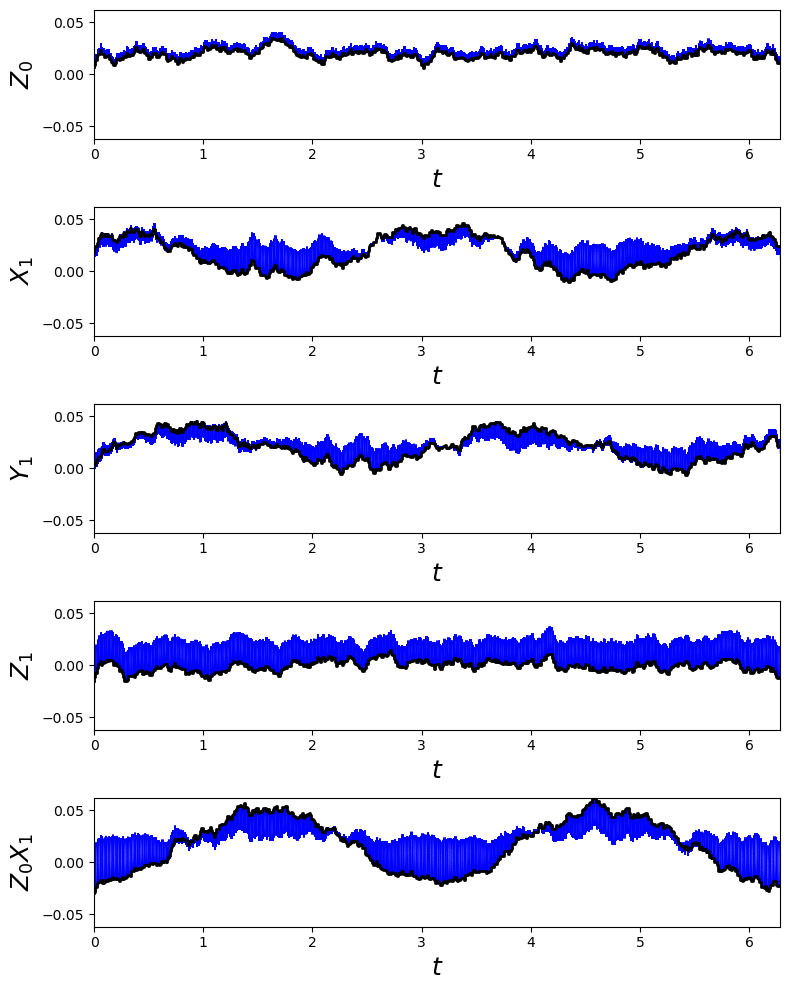

In [8]:
###Plot the resulting pulses. Black line is initialization and blue is final pulse
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);


In [9]:
### Matrix with |00> --> |00> transition amplitude normalized to 1
result.U_f/result.U_f[0,0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j         -0.00392534-0.1162646j   0.        +0.j
   0.        +0.j        ]
 [ 0.04268566-0.10821645j  0.94209893+0.33533507j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.15338249+0.07052211j
   0.97433291+0.18896744j]
 [ 0.        +0.j          0.        +0.j          0.97954306+0.15977702j
   0.11951375+0.11923096j]]

In [10]:
### Real part of the inner product and fidelity respectively
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f)) ** 2

(0.69457667221069, 0.9648543316472202)